In [1]:
%pylab inline
import numpy as np
from scipy.integrate import odeint
import itertools
from SparseARD import*
from Oracle_Training import *
import json
np.random.seed(0)

retrain = False

noise_percent = 1
tol = 1e-8 # tolerance for ARD algorithm
verbose = False

Populating the interactive namespace from numpy and matplotlib


(0, 200)

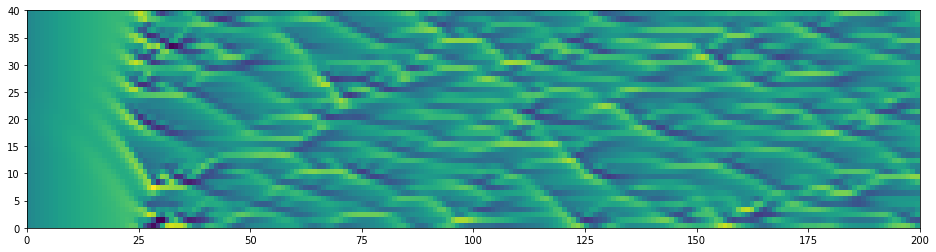

In [2]:
n = 40
F = 16.

def shift(x, s):
    if s == 0: return x
    else: return np.concatenate([x[s:], x[:s]])
    
def L96(x,t,params):
    F = params
    return (shift(x,1)-shift(x,-2))*shift(x,-1)-x+F

x0 = np.exp(-(np.arange(n)-n/2)**2 / 16)

m = 200
dt = 0.05

t = dt*np.arange(m)
X = odeint(L96, x0, t, (F,))
t = t

figure(figsize = (16,4))
pcolor(X.T)
xlim(0,m)

In [3]:
p = 2

measurement_noise = 0.01*noise_percent*np.std(X)*np.random.randn(*X.shape)
X_obs = X + measurement_noise

feature_maps, feature_descriptions = polynomial_feature_maps(n, p)
d = len(feature_maps)
print(d)
    
Theta = np.hstack([f(X_obs) for f in feature_maps])
Theta_clean = np.hstack([f(X) for f in feature_maps])

861


In [4]:
if retrain:

    L1_err = {'ARD' : [], 'ARDr' : [], 'ARDvi' : [], 'mSTSBL' : [], 'lSTSBL' : [], 'dSTSBL' : []}
    L2_err = {'ARD' : [], 'ARDr' : [], 'ARDvi' : [], 'mSTSBL' : [], 'lSTSBL' : [], 'dSTSBL' : []}
    Added = {'ARD' : [], 'ARDr' : [], 'ARDvi' : [], 'mSTSBL' : [], 'lSTSBL' : [], 'dSTSBL' : []}
    Missed = {'ARD' : [], 'ARDr' : [], 'ARDvi' : [], 'mSTSBL' : [], 'lSTSBL' : [], 'dSTSBL' : []}
    Xi = {'ARD':[], 'ARDr' : [], 'ARDvi' : [], 'mSTSBL' : [], 'lSTSBL' : [], 'dSTSBL' : []}

    for dim in range(40):

        print('Dimension', dim+1, 'of', str(40)+'.')

        # True predictor
        e_dim = np.zeros(40); e_dim[dim]=1  # linear term in this dimension
        e_dim_pm1 = np.zeros(40); e_dim_pm1[(dim+1)%n]=1; e_dim_pm1[(dim-1)%n]=1  # quadratic x_{dim +- 1}
        e_dim_m2m1 = np.zeros(40); e_dim_m2m1[(dim-2)%n]=1; e_dim_m2m1[(dim-1)%n]=1  # quadratic x_{dim - 2}x_{dim - 1}

        c_dim = np.where(np.array([np.all(feature_descriptions[j] == \
                                          e_dim.astype(int)) for j in range(d)]).astype(int) == 1)[0]
        c_dim_pm1 = np.where(np.array([np.all(feature_descriptions[j] == \
                                          e_dim_pm1.astype(int)) for j in range(d)]).astype(int) == 1)[0]
        c_dim_m2m1 = np.where(np.array([np.all(feature_descriptions[j] == \
                                          e_dim_m2m1.astype(int)) for j in range(d)]).astype(int) == 1)[0]

        xi_true = np.zeros((len(feature_maps),1))
        xi_true[0,0] = F
        xi_true[c_dim,0] = -1
        xi_true[c_dim_pm1,0] = 1 
        xi_true[c_dim_m2m1,0] = -1
        xi = xi_true

        y = FiniteDiff(X_obs, dt, 1, 6)[:,dim].reshape(m,1)

        # Test each method
        gamma_ARD,sigma2_ARD,mu_xi_ARD,_ = SBL([Theta,y], \
                                           sigma2=1, \
                                           estimate_sigma=True, \
                                           maxit=500, \
                                           verbose=verbose, \
                                           tol=tol)
        ARD_results = gamma_ARD,sigma2_ARD,mu_xi_ARD

        lams = [np.linalg.norm(y)**2*l for l in [0,1e-3,1e-2,1e-1,1e0,1e1,1e2]]
        gamma_ARDr, sigma2_ARDr, mu_xi_ARDr = Train_ARDr(Theta,y,xi_true,ARD_results=ARD_results,lams = lams)

        alphas = [1,2,4,8,10,16,32,64,128,256,512]
        gamma_ARDvi, sigma2_ARDvi, mu_xi_ARDvi = Train_ARDvi(Theta,y,xi_true,ARD_results=ARD_results, alphas=alphas)

        taus = [0,1e-5,1e-4,1e-3,1e-2,1e-1,1]
        gamma_STSBL, sigma2_STSBL, mu_xi_STSBL = Train_M_STSBL(Theta,y,xi_true,ARD_results=ARD_results, taus=taus)

        taus = [np.inf,1e-8,1e-6,1e-4,1e-2,1e-1,1,2,5,10]
        gamma_lSTSBL, sigma2_lSTSBL, mu_xi_lSTSBL = Train_L_STSBL(Theta,y,xi_true,ARD_results=ARD_results, taus=taus)

        taus = [0,1e-2,1e-1,1,1e1,1e2,1e3,1e4]
        gamma_dSTSBL, sigma2_dSTSBL, mu_xi_dSTSBL = Train_MAP_STSBL(Theta,y,xi_true,ARD_results=ARD_results, taus=taus)

        # Record predictions
        Xi['ARD'].append(list(mu_xi_ARD.flatten()))
        Xi['ARDr'].append(list(mu_xi_ARDr.flatten()))
        Xi['ARDvi'].append(list(mu_xi_ARDvi.flatten()))
        Xi['mSTSBL'].append(list(mu_xi_STSBL.flatten()))
        Xi['lSTSBL'].append(list(mu_xi_lSTSBL.flatten()))
        Xi['dSTSBL'].append(list(mu_xi_dSTSBL.flatten()))

        # Record errors
        L1_err['ARD'].append(np.linalg.norm(xi - mu_xi_ARD, 1))
        L1_err['ARDr'].append(np.linalg.norm(xi - mu_xi_ARDr, 1))
        L1_err['ARDvi'].append(np.linalg.norm(xi - mu_xi_ARDvi, 1))
        L1_err['mSTSBL'].append(np.linalg.norm(xi - mu_xi_STSBL, 1))
        L1_err['lSTSBL'].append(np.linalg.norm(xi - mu_xi_lSTSBL, 1))
        L1_err['dSTSBL'].append(np.linalg.norm(xi - mu_xi_dSTSBL, 1))

        L2_err['ARD'].append(np.linalg.norm(xi - mu_xi_ARD, 2))
        L2_err['ARDr'].append(np.linalg.norm(xi - mu_xi_ARDr, 2))
        L2_err['ARDvi'].append(np.linalg.norm(xi - mu_xi_ARDvi, 2))
        L2_err['mSTSBL'].append(np.linalg.norm(xi - mu_xi_STSBL, 2))
        L2_err['lSTSBL'].append(np.linalg.norm(xi - mu_xi_lSTSBL, 2))
        L2_err['dSTSBL'].append(np.linalg.norm(xi - mu_xi_dSTSBL, 2))

        _,added,missed = sparsity_err(mu_xi_ARD,xi)
        Added['ARD'].append(added)
        Missed['ARD'].append(missed)

        _,added,missed = sparsity_err(mu_xi_ARDr,xi)
        Added['ARDr'].append(added)
        Missed['ARDr'].append(missed)

        _,added,missed = sparsity_err(mu_xi_ARDvi,xi)
        Added['ARDvi'].append(added)
        Missed['ARDvi'].append(missed)

        _,added,missed = sparsity_err(mu_xi_STSBL,xi)
        Added['mSTSBL'].append(added)
        Missed['mSTSBL'].append(missed)

        _,added,missed = sparsity_err(mu_xi_lSTSBL,xi)
        Added['lSTSBL'].append(added)
        Missed['lSTSBL'].append(missed)

        _,added,missed = sparsity_err(mu_xi_dSTSBL,xi)
        Added['dSTSBL'].append(added)
        Missed['dSTSBL'].append(missed)

In [5]:
if retrain:
    with open('./saved_results/L96_results.json','w') as f:
        json.dump({'L2_err': L2_err, \
                   'L1_err': L1_err, \
                   'Added' : Added, \
                   'Missed' : Missed, \
                   'Xi' : Xi}, f)
else:
    with open('./saved_results/L96_results.json','r') as f:
        results = json.load(f)
    L2_err = results['L2_err']    
    L1_err = results['L1_err']    
    Added = results['Added']
    Missed = results['Missed']
    Xi = results['Xi']

([<matplotlib.axis.XTick at 0x7f39a132f7f0>,
 <a list of 6 Text xticklabel objects>)

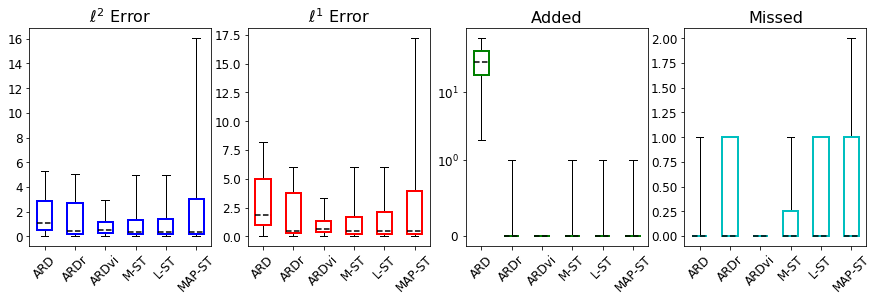

In [6]:
figure(figsize = (15,4))

lw = 2
label_fs = 16

whis = [0,100]
showfliers = False

subplot(1,4,1)
title(r'$\ell^2$ Error', fontsize = 16)
bp1 = boxplot([L2_err[key] for key in L2_err.keys()], positions = np.arange(6), \
              patch_artist=True, whis=whis, showfliers=showfliers)
for box, whisker,cap, median in zip(bp1['boxes'], bp1['whiskers'], bp1['caps'], bp1['medians']):
    box.set(color='b', linewidth=lw)
    box.set(facecolor = 'w' )
    median.set(color='k', linestyle = '--', linewidth=1.5)
yticks(fontsize = 12)
xticks(np.arange(6), ['ARD','ARDr','ARDvi','M-ST','L-ST','MAP-ST'], fontsize = 12, rotation=45)
    
subplot(1,4,2)
title(r'$\ell^1$ Error', fontsize = 16)
bp2 = boxplot([L1_err[key] for key in L1_err.keys()], positions = np.arange(6), patch_artist=True, whis=whis, showfliers=showfliers)
for box, whisker, cap, median in zip(bp2['boxes'], bp2['whiskers'], bp2['caps'], bp2['medians']):
    box.set(color='r', linewidth=lw)
    box.set(facecolor = 'w' )
    median.set(color='k', linestyle = '--', linewidth=1.5)
yticks(fontsize = 12)
xticks(np.arange(6), ['ARD','ARDr','ARDvi','M-ST','L-ST','MAP-ST'], fontsize = 12, rotation=45)

subplot(1,4,3)
title(r'Added', fontsize = 16)
bp3 = boxplot([Added[key] for key in Added.keys()], positions = np.arange(6), patch_artist=True, whis=whis, showfliers=showfliers)
for box, whisker, cap, median in zip(bp3['boxes'], bp3['whiskers'], bp3['caps'], bp3['medians']):
    box.set(color='g', linewidth=lw)
    box.set(facecolor = 'w' )
    median.set(color='k', linestyle = '--', linewidth=1.5)
yticks(fontsize = 12)
xticks(np.arange(6), ['ARD','ARDr','ARDvi','M-ST','L-ST','MAP-ST'], fontsize = 12, rotation=45)
yscale('symlog', linthreshy = 1)

subplot(1,4,4)
title(r'Missed', fontsize = 16)
bp4 = boxplot([Missed[key] for key in Missed.keys()], positions = np.arange(6), patch_artist=True, whis=whis, showfliers=showfliers)
for box, whisker, cap, median in zip(bp4['boxes'], bp4['whiskers'], bp4['caps'], bp4['medians']):
    box.set(color='c', linewidth=lw)
    box.set(facecolor = 'w' )
    median.set(color='k', linestyle = '--', linewidth=1.5)
yticks(fontsize = 12)
xticks(np.arange(6), ['ARD','ARDr','ARDvi','M-ST','L-ST','MAP-ST'], fontsize = 12, rotation=45)